In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
from tqdm import tqdm

In [2]:
SEED = 5678

np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

#### Source sequence X

In [3]:
X_chars = [chr(asc_idx) for asc_idx in range(ord('a'), ord('z')+1)] \
    + ['<unk>', '<pad>', '<start>', '<end>']

X_lexicon = { ch:idx for idx, ch in enumerate(X_chars) }

In [4]:
m = 16
Tx = 50
X_lexicon_size = len(X_lexicon) # 30

# (m, Tx)
X = torch.randint(low=0, high=X_lexicon_size, size=(m, Tx))
print(f'{X.size() = }')
print(f'{X[0] = }')

X.size() = torch.Size([16, 50])
X[0] = tensor([10, 15, 20,  8, 25, 14, 23, 27, 26,  1, 20,  7,  1,  1,  4, 14,  0, 13,
         3, 12,  4,  1, 27, 20, 25,  7,  2, 21, 26, 27, 19,  5, 23, 12, 13, 21,
         3,  1, 26, 15, 21,  5,  6,  4,  6,  0, 20, 10,  9,  9])


#### Target sequence Y

In [5]:
Y_chars = [chr(asc_idx) for asc_idx in range(ord('0'), ord('9')+1)] \
    + ['<unk>', '<pad>', '<start>', '<end>']
Y_lexicon = { ch:idx for idx, ch in enumerate(Y_chars) }

In [6]:
m = 16
Ty = 40
Y_lexicon_size = len(Y_lexicon) # 14

# (m, Ty)
Y = torch.randint(low=0, high=Y_lexicon_size, size=(m, Ty))
print(f'{Y.size() = }')
print(f'{Y[0] = }')

Y.size() = torch.Size([16, 40])
Y[0] = tensor([ 0,  8,  1,  4, 10,  1,  1,  7,  9,  7,  9,  0,  1,  5,  5,  4, 13, 13,
        12, 13,  0,  1,  9,  8,  1,  5,  5,  7,  0,  2, 10,  2,  9,  3,  1,  4,
         9,  0,  3,  9])


# 1. Components
[https://arxiv.org/pdf/1706.03762v5.pdf](https://arxiv.org/pdf/1706.03762v5.pdf)

<img src="assets/transformer_transformer.png" width="400">


### 1.1 Embedding
- Encode **word meaning info**

In [7]:
class Embbeding(nn.Module):
    def __init__(self, lexicon_size, embed_dim):
        super(Embbeding, self).__init__()

        # Emb
        self.embedding = nn.Embedding(
            num_embeddings=lexicon_size,
            embedding_dim=embed_dim)

    def forward(self, inp):
        """
        Arguments:
            inp (Long tensor(m, T))         : Input sequence, categorical Long
                m : batch size
                T : sequence length
        Returns:
            emb (tensor(m, T, embed_dim))   : Embbeding sequence
        """
        # (m, T) -> (m, T, emb_dim)
        return self.embedding(inp)

In [8]:
embed_x = Embbeding(
    lexicon_size=X_lexicon_size,
    embed_dim=64)
X_emb = embed_x(X)

# (m, Tx, emb_dim)
print(f'{X_emb.size() = }')

X_emb.size() = torch.Size([16, 50, 64])


In [9]:
embed_y = Embbeding(
    lexicon_size=Y_lexicon_size,
    embed_dim=64)
Y_emb = embed_y(Y)

# (m, Ty, emb_dim)
print(f'{Y_emb.size() = }')

Y_emb.size() = torch.Size([16, 40, 64])


### 1.2 Positional Encoder
- Encode **word positioning info** (pos of a word in a sentence)
- PE = a matrix size (Tx, emb_dim)

$$\begin{cases}
\text{PE(pos, 2i)} = \sin \left(\frac{\text{pos}}{10000^{2i / d}} \right) \text{ (even i)} \\
\text{PE(pos, 2i + 1)} = \cos \left(\frac{\text{pos}}{10000^{2i / d}} \right) \text{ (odd i)}
\end{cases}$$

- X_embed_pe = A*embed + PE
    + Amplify embed values to prevent embedding info supressed by PE info after adding

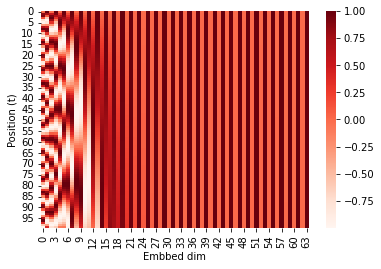

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt
max_length, emb_dim = 100, 64

# Init PE matrix
#    (T, emb_dim)
pe = np.zeros((max_length, emb_dim))

# Assign pe values
for t in range(max_length):
    for i in range(0, emb_dim, 2):
        pe[t, i] = np.sin(
            t / (10000 ** ((2 * i) / emb_dim)))
        pe[t, i+1] = np.cos(
            t / (10000 ** ((2 * (i + 1)) / emb_dim)))
        
# Plot
sns.heatmap(pe, cmap=plt.cm.Reds)
plt.xlabel('Embbed dim')
plt.ylabel('Position (t)')
plt.show()

#### Implementation 1 (Static PE)

In [11]:
from torch.autograd import Variable

class PositionalEncoder(nn.Module):
    def __init__(self, max_length, embed_dim):
        super(PositionalEncoder, self).__init__()
        self.emb_dim = embed_dim

        # Init PE matrix
        #    (T, emb_dim)
        pe = torch.zeros(max_length, self.emb_dim)

        # Assign pe values
        for t in range(max_length):
            for i in range(0, self.emb_dim, 2):
                pe[t, i] = np.sin(
                    t / (10000 ** ((2 * i) / self.emb_dim)))
                pe[t, i+1] = np.cos(
                    t / (10000 ** ((2 * (i + 1)) / self.emb_dim)))

        # (max_length, emb_dim) -> (1, max_length, emb_dim)
        self.register_buffer('pe', pe.unsqueeze(0))

    def forward(self, m, T, device='cpu'):
        """
        Add position encoding info to emb

        Arguments:
            m (int)     : batch_size
            T (int)     : sequence length
        Returns:
            pos (tensor(m, T, embed_dim))   : Pos Encoding
        """
        # Retrieve pe
        return Variable(self.pe[:,:T,:], requires_grad=False).to(device).expand(m,-1,-1)

#### Implementation 2 (Dynamic)

In [12]:
class PositionalEncoder(nn.Module):
    def __init__(self, max_length, embed_dim):
        super(PositionalEncoder, self).__init__()
        self.emb_dim = embed_dim

        self.pos_encode = nn.Embedding(
            num_embeddings=max_length,
            embedding_dim=embed_dim)


    def forward(self, m, T, device='cpu'):
        """
        Add position encoding info to emb

        Arguments:
            m (int)     : batch_size
            T (int)     : sequence length
        Returns:
            pos (tensor(m, T, embed_dim))   : Pos Encoding
        """
        pe = torch.arange(0, T).to(device).expand(m, -1) 
        return self.pos_encode(pe)

In [13]:
pos_encoder_x = PositionalEncoder(
    max_length=100,
    embed_dim=64)

X_pos = pos_encoder_x(m=m, T=Tx)
print(f'{X_pos.size() = }')

X_emb_pos = np.sqrt(64)*X_emb + X_pos
print(f'{X_emb_pos.size() = }')

X_pos.size() = torch.Size([16, 50, 64])
X_emb_pos.size() = torch.Size([16, 50, 64])


In [14]:
pos_encoder_y = PositionalEncoder(
    max_length=100,
    embed_dim=64)

Y_pos = pos_encoder_x(m=m, T=Ty)
print(f'{Y_pos.size() = }')

Y_emb_pos = np.sqrt(64)*Y_emb + Y_pos
print(f'{Y_emb_pos.size() = }')

Y_pos.size() = torch.Size([16, 40, 64])
Y_emb_pos.size() = torch.Size([16, 40, 64])


### 1.3 Multi-Headed Attention

#### Masking
- **pad token mask**: Suppress attention where `<pad>` exists
- **No peaking forward Mask**: For Target sequence, prevent the decoder paying attention ahead toward the rest of the translated sentence when predicting the next word.

#### Source mask example

```python
# X_seq = (3, 14), pad_token = 0
X_seq = tensor([
    [ 101, 1045, 2123, 1005, 1056, 2113, 1998, 1045, 2123, 1005, 1056, 2729, 1012,  102],
    [ 101, 2054, 2395, 2079, 2017, 2444, 2006, 1029,  102,    0,    0,    0, 0,    0],
    [ 101, 3419, 5598, 2046, 1996, 4770, 1012,  102,    0,    0,    0,    0, 0,    0]])

# X_mask = (3, 1, 1, 14)
X_mask = tensor([
        [[[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]],
        [[[1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0]]],
        [[[1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0]]]], dtype=torch.int8)
```

In [15]:
def create_mask_source(X_seq, pad_token, device='cpu'):
    """
    Create mask values (0 = masked, 1 = keep)

    Arguments:
        X_seq (Long tensor(m, T)) : Source Sequence, categorical Long
            m : batch size
            T : sequence length
        pad_token (int)           : token value of <pad>, get from X_lexicon['<pad>']

    Returns:
        mask (Long tensor(m, 1, 1, T)) : attention mask(val=1:keep or val=0:supress) for source sequence
    """
    # Get dim
    m, Tx = X_seq.size()

    # padding token Mask
    #    mask = 1 if seq != padding token else 0
    #    (m, T) -> (m, 1, 1, T)
    padding_mask = (X_seq != pad_token) \
        .unsqueeze(dim=1).unsqueeze(dim=2) \
        .to(device)

    return padding_mask \
        .to(torch.int8).requires_grad_(False)

In [16]:
X_mask = create_mask_source(X, pad_token=X_lexicon['<pad>'])
print(f'{X_mask.size() = }')

X_mask.size() = torch.Size([16, 1, 1, 50])


#### Target mask example

```python
# Y_seq = (3, 12), pad_token = 1
Y_seq = tensor([
    [0, 70, 17, 55, 6, 70, 17,  2665, 25349, 21573, 2, 1],
    [0, 88, 235, 25, 109, 142, 2, 1, 1, 1, 1, 1],
    [0, 33939, 1945, 307, 1005, 1388, 9479, 27375, 2, 1, 1, 1]])

# Y_mask = (3, 1, 12, 12)
Y_mask = tensor([[
         [[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
          [1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0],
          [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
          [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
          [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0]]],

        [[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
          [1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0],
          [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
          [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
          [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
          [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
          [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
          [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
          [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0]]],

        [[[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
          [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
          [1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0],
          [1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0],
          [1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0],
          [1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0],
          [1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0]]]], dtype=torch.int8)
```

In [17]:
def create_mask_target(Y_seq, pad_token, device='cpu'):
    """
    Create mask values (0 = masked, 1 = keep)

    Arguments:
        Y_seq (Long tensor(m, T)) : Target Sequence, categorical Long
            m : batch size
            T : sequence length
        pad_token (int)           : token value of <pad>, get from Y_lexicon['<pad>']

    Returns:
        mask (Long tensor(m, 1, T, T)) : attention mask(val=1:keep or val=0:supress) for target sequence
    """
    # Get dim
    m, Ty = Y_seq.size()

    # padding token Mask
    #    mask = 1 if seq != padding token else 0
    #    (m, T) -> (m, 1, 1, T) -> (m, 1, T, T)
    padding_mask = (Y_seq != pad_token) \
        .unsqueeze(dim=1).unsqueeze(dim=2) \
        .expand(m, 1, Ty, Ty).to(torch.bool) \
        .to(device)

    # No peaking forward Mask: (m, 1, T, T)
    #   (T, T) = Lower triangular matrix
    nopeak_mask = torch.tril(torch.ones( (Ty, Ty) )) \
        .unsqueeze(dim=0).unsqueeze(dim=1) \
        .expand(m, 1, Ty, Ty).to(torch.bool) \
        .to(device)

    return (padding_mask & nopeak_mask) \
        .to(torch.int8).requires_grad_(False)

In [18]:
Y_mask = create_mask_target(Y, pad_token=Y_lexicon['<pad>'])
print(f'{Y_mask.size() = }')

Y_mask.size() = torch.Size([16, 1, 40, 40])


#### Scaled Dot-Product Attention

$$\text{Attention}(Q,K,V) = \text{softmax} \left( \frac{QK^T}{\sqrt{d_k}} \right) V$$

<img src="assets/transformer_SDPAtt.png" width="200">

#### Multi-head Attention

<img src="assets/transformer_multiheadAtt.png" width="300">

In [19]:
class MultiHeadAttention(nn.Module):
    def __init__(self, embed_dim, num_heads, dropout=0.1):
        super(MultiHeadAttention, self).__init__()

        # Params
        self.emb_dim = embed_dim
        self.h = num_heads

        # Split emb_dim = num_head * head_dim
        self.head_dim = self.emb_dim // self.h

        assert (
            self.emb_dim == self.h * self.head_dim
        ), "Embedding size needs to be divisible by num_heads"

        # Linear key, queries, values
        self.q_linears = nn.Linear(self.emb_dim, self.emb_dim)
        self.k_linears = nn.Linear(self.emb_dim, self.emb_dim)
        self.v_linears = nn.Linear(self.emb_dim, self.emb_dim)

        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(self.h * self.head_dim, self.emb_dim)

    def __scaled_dot_product_att(self, q, k, v, mask=None, dropout=None):
        """
        Compute scaled dot product attention

        Arguments:
            q (tensor(m, num_heads, T_query, head_dim))        : query
            k (tensor(m, num_heads, T_key, head_dim))          : key
            v (tensor(m, num_heads, T_val, head_dim))          : value
            mask (tensor None or (m, 1, T, T) or (m, 1, 1, T)) : attention mask, 1=keep, 0=suppress att
            dropout (None or nn.Dropout)                       : dropout function
        Returns:
            context_vector (tensor(m, T_query, num_heads, head_dim)): scaled dot product context vector
            attention (tensor(m, num_heads, T_query, T_key))        : scaled dot product attention
        """
        # energy = (m, num_heads, T_query, head_dim) x (m, num_heads, head_dim, T_key)
        #    -> (m, num_heads, T_query, T_key)
        energy = torch.matmul(q, k.permute(0, 1, 3, 2)) / np.sqrt(self.emb_dim)

        if mask is not None:
            # Masking, suppress energy/attention where mask == 0
            energy = energy.masked_fill(mask == 0, float('-1e20'))

        # attention(alpha_ij) = (m, num_heads, T_query, T_key)
        attention = F.softmax(energy, dim=3)
        if dropout is not None:
            attention = dropout(attention)

        # context_vector = attention x v
        #   (m, num_heads, T_query, T_key) x (m, num_heads, T_val, head_dim)
        #       -> (m, num_heads, T_query, head_dim) -> (m, T_query, num_heads, head_dim)
        context_vector = torch.matmul(attention, v) \
            .permute(0, 2, 1, 3).contiguous()
        return context_vector, attention

    def forward(self, Q, K, V, mask=None):
        """
        Compute Multihead attention

        Arguments:
            Q (tensor(m, T_query, emb_dim))        : Query
            K (tensor(m, T_key, emb_dim))          : Key
            V (tensor(m, T_val, emb_dim))          : Value
            mask (tensor None or (m, 1, T, T) or (m, 1, 1, T)) : attention mask, 1=keep, 0=suppress att
        Returns:
            context_vector (tensor(m, T_query, emb_dim))       : multihead context_vector
            attention (tensor(m, num_heads, T_query, T_key))   : scaled dot product attention
        """

        # Batch size
        m = Q.size(0)

        # Compute key, queries, values linears, then split q,k,v -> multiple heads
        #   (m, T_query, emb_dim) -> (m, T_query, num_heads, head_dim) -> (m, num_heads, T_query, head_dim)
        #   (m, T_key,   emb_dim) -> (m, T_key,   num_heads, head_dim) -> (m, num_heads, T_key, head_dim)
        #   (m, T_val,   emb_dim) -> (m, T_val,   num_heads, head_dim) -> (m, num_heads, T_val, head_dim)
        queries = self.q_linears(Q) \
            .view(m, -1, self.h, self.head_dim) \
            .permute(0, 2, 1, 3)
        keys = self.k_linears(K) \
            .view(m, -1, self.h, self.head_dim) \
            .permute(0, 2, 1, 3)
        values = self.v_linears(V) \
            .view(m, -1, self.h, self.head_dim) \
            .permute(0, 2, 1, 3)

        # Compute scaled dot product context_vector
        #    (m, T_query, num_heads, head_dim)
        context_vector, attention = self.__scaled_dot_product_att(
            q=queries, k=keys, v=values,
            mask=mask, dropout=self.dropout)

        # concatenate all heads
        #    (m, T_query, emb_dim)
        context_vector = context_vector.view(m, -1, self.h * self.head_dim)

        # Compute last linear
        context_vector = self.linear(context_vector)
        return context_vector, attention

In [20]:
self_att_x = MultiHeadAttention(embed_dim=64, num_heads=4, dropout=0.1)

X_self_att, _ = self_att_x(Q=X_emb_pos, K=X_emb_pos, V=X_emb_pos, mask=X_mask)
print(f'{X_self_att.size() = }')

X_self_att.size() = torch.Size([16, 50, 64])


In [21]:
self_att_y = MultiHeadAttention(embed_dim=64, num_heads=4, dropout=0.1)

Y_self_att, _ = self_att_y(Q=Y_emb_pos, K=Y_emb_pos, V=Y_emb_pos, mask=Y_mask)
print(f'{Y_self_att.size() = }')

Y_self_att.size() = torch.Size([16, 40, 64])


### 1.4 Layer Norm
- Perform Layer Normalization across each example, agg `feature dimensions`
    + $\gamma$: weight parameter, grad = True
    + $\beta$: bias parameter, grad = True

$$y  = \frac{x - E(x)}{\sqrt{\text{Var}(x) + \epsilon}} * \gamma + \beta$$

#### Implementation 1

In [22]:
class LayerNorm(nn.Module):
    def __init__(self, normalized_shape, eps=1e-5):
        super(LayerNorm, self).__init__()
        self.eps = eps

        # Trainable params
        self.gamma = nn.Parameter(torch.ones(normalized_shape), requires_grad=True)
        self.beta = nn.Parameter(torch.zeros(normalized_shape), requires_grad=True)

    def forward(self, x):
        """
        Compute Norm across each example, agg (emb_dim), same as nn.LayerNorm(emb_dim)

        Arguments:
            x (tensor(m, T, emb_dim))  : Input
        Returns:
            y (tensor(m, T, emb_dim))  : Norm output
        """
        E_x = x.mean(dim=-1, keepdim=True)
        Var_x = torch.var(x, dim=-1, keepdim=True)
        return (x - E_x) / torch.sqrt(Var_x + self.eps) * self.gamma + self.beta

#### Implementation 2 (Built-in)

In [23]:
class LayerNorm(nn.Module):
    def __init__(self, normalized_shape, eps=1e-5):
        super(LayerNorm, self).__init__()
        self.ln = nn.LayerNorm(
            normalized_shape=normalized_shape,
            eps=1e-05)


    def forward(self, x):
        """
        Compute Norm across each example, agg (emb_dim), same as nn.LayerNorm(emb_dim)

        Arguments:
            x (tensor(m, T, emb_dim))  : Input
        Returns:
            y (tensor(m, T, emb_dim))  : Norm output
        """
        return self.ln(x)

In [24]:
emb_dim = 64

norm = LayerNorm(normalized_shape=emb_dim, eps=1e-6)

X_norm = norm(X_self_att)
print(f'{X_norm.size() = }')

X_norm.size() = torch.Size([16, 50, 64])


### 1.5 Feed Forward

In [25]:
class FeedForward(nn.Module):
    def __init__(self, embed_dim, forward_expansion_dim=2048, dropout=0.1):
        super(FeedForward, self).__init__()

        self.feed_forward = nn.Sequential(
            nn.Linear(embed_dim, forward_expansion_dim),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(forward_expansion_dim, embed_dim),
        )
    def forward(self, inp):
        """
        Apply feed forward toward last dimension

        Arguments:
            inp (tensor(m,*,embed_dim))  : Input tensor
        Returns:
            out (tensor(m,*,embed_dim))  : Output tensor
        """
        return self.feed_forward(inp)

In [26]:
feedforward = FeedForward(embed_dim=64, forward_expansion_dim=2048, dropout=0.1)

ff = feedforward(X_norm)
print(f'{ff.size() = }')

ff.size() = torch.Size([16, 50, 64])


# 2. Encoder
### 2.1 Encoder Block

<img src="assets/transformer_blk_encoder.png" width="150">


In [27]:
class EncoderBlock(nn.Module):
    def __init__(self,
            embed_dim, num_heads,
            dropout=0.1, forward_expansion_dim=2048, eps=1e-5):
        super(EncoderBlock, self).__init__()

        # Layer 1
        self.multihead_attention = MultiHeadAttention(
            embed_dim=embed_dim, num_heads=num_heads,
            dropout=dropout)
        self.norm_1 = LayerNorm(
            normalized_shape=embed_dim,
            eps=eps)
        self.dropout_1 = nn.Dropout(dropout)

        # Layer 2
        self.feed_forward = FeedForward(
            embed_dim=embed_dim, forward_expansion_dim=forward_expansion_dim,
            dropout=dropout)
        self.norm_2 =LayerNorm(
            normalized_shape=embed_dim,
            eps=eps)
        self.dropout_2 = nn.Dropout(dropout)

    def forward(self, X_emb_pos, X_mask):
        """
        Arguments:
            X_emb_pos (tensor(m, Tx, emb_dim) : Source sequence encoded with embbeding and position
            X_mask (Long tensor(m, 1, 1, T))  : Source sequence attention mask(val=1:keep or val=0:supress)
        Returns:
            X_enc (tensor(m, Tx, emb_dim))    : encoder output from source seq
        """
        # Layer 1
        X_att, _ = self.multihead_attention(
            Q=X_emb_pos, K=X_emb_pos, V=X_emb_pos,
            mask=X_mask)
        X_norm_1 = self.dropout_1(
            self.norm_1(X_emb_pos + X_att))

        # Layer 2
        ff = self.feed_forward(X_norm_1)
        X_enc = self.dropout_2(
            self.norm_2(X_norm_1 + ff))

        return X_enc

### 2.2 Encoder

<img src="assets/transformer_encoder.png" width="250">

In [28]:
class Encoder(nn.Module):
    def __init__(self,
            Tx, X_lexicon_size, embed_dim,
            num_layers, num_heads,
            forward_expansion_dim=1024,
            dropout=0.1, eps=1e-5):
        super(Encoder, self).__init__()
        # Params
        self.embed_dim = embed_dim

        # X = emb + pe
        self.input_embedding = Embbeding(
            lexicon_size=X_lexicon_size, embed_dim=embed_dim)
        self.pos_encoding = PositionalEncoder(
            max_length=100,
            embed_dim=embed_dim)
        self.dropout = nn.Dropout(dropout)

        # Enc blocks
        self.enc_blocks = nn.ModuleList([
            EncoderBlock(
                embed_dim=embed_dim, num_heads=num_heads,
                dropout=dropout, forward_expansion_dim=forward_expansion_dim, eps=eps
            ) for _ in range(num_layers)
        ])

    def forward(self, X_seq, X_mask, device='cpu'):
        """
        Arguments:
            X_seq (Long tensor(m, Tx)         : Source sequence, categorical Long
            X_mask (Long tensor(m, 1, 1, T))  : Source sequence attention mask(val=1:keep or val=0:supress)
        Returns:
            X_enc (tensor(m, Tx, emb_dim))    : encoder output from source seq
        """
        # Input emb, pos encoding
        m, Tx = X_seq.size()
        X_emb = self.input_embedding(X_seq)
        X_pos = self.pos_encoding(m=m, T=Tx, device=device)

        # X_emb_pos = rescaled*emb + position encoded
        X_enc = self.dropout(np.sqrt(self.embed_dim)*X_emb + X_pos)

        # Enc blocks
        for enc_blk in self.enc_blocks:
            X_enc = enc_blk(
                X_emb_pos=X_enc, X_mask=X_mask)

        return X_enc

In [29]:
encoder = Encoder(
    Tx=Tx, X_lexicon_size=X_lexicon_size, embed_dim=64,
    num_layers=3, num_heads=4,
    forward_expansion_dim=1024,
    dropout=0.1, eps=1e-6)

X_enc = encoder(X_seq=X, X_mask=X_mask)
print(f'{X_enc.size() = }')

X_enc.size() = torch.Size([16, 50, 64])


# 3. Decoder
### 3.1 Decoder Block

<img src="assets/transformer_blk_decoder.png" width="150">

In [30]:
class DecoderBlock(nn.Module):
    def __init__(self,
            embed_dim, num_heads,
            dropout=0.1, forward_expansion_dim=2048, eps=1e-5):
        super(DecoderBlock, self).__init__()
        # Layer 1
        self.masked_multihead_attention = MultiHeadAttention(
            embed_dim=embed_dim, num_heads=num_heads,
            dropout=dropout)
        self.norm_1 = LayerNorm(
            normalized_shape=embed_dim,
            eps=eps)
        self.dropout_1 = nn.Dropout(dropout)

        # Layer 2
        self.multihead_attention = MultiHeadAttention(
            embed_dim=embed_dim, num_heads=num_heads,
            dropout=dropout)
        self.norm_2 = LayerNorm(
            normalized_shape=embed_dim,
            eps=eps)
        self.dropout_2 = nn.Dropout(dropout)

        # Layer 3
        self.feed_forward = FeedForward(
            embed_dim=embed_dim, forward_expansion_dim=forward_expansion_dim,
            dropout=dropout)
        self.norm_3 = LayerNorm(
            normalized_shape=embed_dim,
            eps=eps)
        self.dropout_3 = nn.Dropout(dropout)

    def forward(self,
            Y_emb_pos, Y_mask,
            X_enc, X_mask):
        """
        Arguments:
            Y_emb_pos (tensor(m, Ty, emb_dim) : Target sequence encoded with embbeding and position
            Y_mask (Long tensor(m, 1, T, T))  : Target sequence attention mask(val=1:keep or val=0:supress)
            X_enc (tensor(m, Tx, emb_dim))    : encoder output from source seq
            X_mask (Long tensor(m, 1, 1, T))  : Source sequence attention mask(val=1:keep or val=0:supress)
        Returns:
            Y_dec (tensor(m, Ty, emb_dim))     : deccoder output
        """
        # Layer 1
        Y_masked_att, _ = self.masked_multihead_attention(
            Q=Y_emb_pos, K=Y_emb_pos, V=Y_emb_pos,
            mask=Y_mask)
        Y_norm_1 = self.dropout_1(
            self.norm_1(Y_emb_pos + Y_masked_att))

        # Layer 2
        Y_att, attention = self.multihead_attention(
            Q=Y_norm_1, K=X_enc, V=X_enc,
            mask=X_mask)
        Y_norm_2 = self.dropout_2(
            self.norm_2(Y_norm_1 + Y_att))

        # Layer 3
        ff = self.feed_forward(Y_norm_2)
        Y_dec = self.dropout_3(
            self.norm_3(Y_norm_2 + ff))

        return Y_dec, attention

### 3.2 Decoder

<img src="assets/transformer_decoder.png" width="200">

In [31]:
class Decoder(nn.Module):
    def __init__(self,
            Ty, Y_lexicon_size, embed_dim,
            num_layers, num_heads,
            forward_expansion_dim=1024,
            dropout=0.1, eps=1e-5):
        super(Decoder, self).__init__()
        # Params
        self.embed_dim = embed_dim

        # Y = emb + pe
        self.input_embedding = Embbeding(
            lexicon_size=Y_lexicon_size, embed_dim=embed_dim)
        self.pos_encoding = PositionalEncoder(
            max_length=100,
            embed_dim=embed_dim)

        self.dropout = nn.Dropout(dropout)

        # Dec blocks
        self.dec_blocks = nn.ModuleList([
             DecoderBlock(
                embed_dim=embed_dim, num_heads=num_heads,
                dropout=dropout, forward_expansion_dim=forward_expansion_dim, eps=eps
            ) for _ in range(num_layers)
        ])

        # Classifier
        self.fc_out = nn.Linear(
            in_features=embed_dim,
            out_features=Y_lexicon_size)

    def forward(self,
            Y_seq, Y_mask,
            X_enc, X_mask, device='cpu'):
        """
        Arguments:
            Y_seq (Long tensor(m, Ty)         : Target sequence, categorical Long
            Y_mask (Long tensor(m, 1, T, T))  : Target sequence attention mask(val=1:keep or val=0:supress)
            X_enc (tensor(m, Tx, emb_dim))    : encoder output from source seq
            X_mask (Long tensor(m, 1, 1, T))  : Source sequence attention mask(val=1:keep or val=0:supress)
        Returns:
            out (tensor(m, Ty, emb_dim))      : log softmax probability predict category in Y_lexicon
        """
        # Input emb, pos encoding
        m, Ty = Y_seq.size()
        Y_emb = self.input_embedding(Y_seq)
        Y_pos = self.pos_encoding(m=m, T=Ty, device=device)

        # Y_emb_pos = rescaled*emb + position encoded
        Y_dec = self.dropout(np.sqrt(self.embed_dim)*Y_emb + Y_pos)

        # Dec blocks
        for dec_blk in self.dec_blocks:
            Y_dec, attention = dec_blk(
                Y_emb_pos=Y_dec, Y_mask=Y_mask,
                X_enc=X_enc, X_mask=X_mask)

        # Classifier
        out = self.fc_out(Y_dec)
        out = F.log_softmax(out, dim=-1)

        return out, attention

In [32]:
decoder = Decoder(
    Ty=Ty, Y_lexicon_size=Y_lexicon_size, embed_dim=64,
    num_layers=3, num_heads=4,
    forward_expansion_dim=1024,
    dropout=0.1, eps=1e-6)

out, _ = decoder(
    Y_seq=Y, Y_mask=Y_mask,
    X_enc=X_enc, X_mask=X_mask)
print(f'{out.size() = }')

out.size() = torch.Size([16, 40, 14])


# 4. Transformer

In [33]:
class Transformer(nn.Module):
    def __init__(self,
            Tx, X_lexicon_size,
            Ty, Y_lexicon_size,
            embed_dim=512,
            num_layers=3, num_heads=4,
            forward_expansion_dim=1024,
            dropout=0.1, eps=1e-6):
        super().__init__()
        self.encoder = Encoder(
            Tx=Tx, X_lexicon_size=X_lexicon_size, embed_dim=embed_dim,
            num_layers=num_layers, num_heads=num_heads,
            forward_expansion_dim=forward_expansion_dim,
            dropout=dropout, eps=eps)
        self.decoder = Decoder(
            Ty=Ty, Y_lexicon_size=Y_lexicon_size, embed_dim=embed_dim,
            num_layers=num_layers, num_heads=num_heads,
            forward_expansion_dim=forward_expansion_dim,
            dropout=dropout, eps=eps)

    def forward(self, X_seq, X_mask, Y_seq, Y_mask, device='cpu'):
        """
        Arguments:
            X_seq (Long tensor(m, Tx)         : Source sequence, categorical Long
            X_mask (Long tensor(m, 1, 1, T))  : Source sequence attention mask(val=1:keep or val=0:supress)
            Y_seq (Long tensor(m, Ty)         : Target sequence, categorical Long
            Y_mask (Long tensor(m, 1, T, T))  : Target sequence attention mask(val=1:keep or val=0:supress)
        Returns:
            out (tensor(m, Ty, emb_dim))      : log softmax probability predict category in Y_lexicon
        """
        X_enc = self.encoder(
            X_seq=X_seq, X_mask=X_mask,
            device=device)
        out, attention = self.decoder(
            Y_seq=Y_seq, Y_mask=Y_mask,
            X_enc=X_enc, X_mask=X_mask,
            device=device)
        return out, attention

In [34]:
transformer = Transformer(
    Tx=Tx, X_lexicon_size=X_lexicon_size,
    Ty=Ty, Y_lexicon_size=Y_lexicon_size,
    embed_dim=512,
    num_layers=4, num_heads=4,
    forward_expansion_dim=1024,
    dropout=0.1, eps=1e-6)

out, _ = transformer(
    X_seq=X, X_mask=X_mask,
    Y_seq=Y, Y_mask=Y_mask)
print(f'{out.size() = }')

out.size() = torch.Size([16, 40, 14])


#### Params count

In [35]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Number of parameters: {count_parameters(transformer)}')

Number of parameters: 21160974


# 5. Train-Test

## 5.1 Problem
- Translate **human language date** to a `machine standard date` format
- Eg:
    + **the 29th of August 1958** -> `1958-08-29`
    + **03/30/1968**              -> `1968-03-30`
    + **24 JUNE 1987**            -> `1987-06-24`

In [36]:
from babel.dates import format_date
from faker import Faker
import random

# data generator
fake = Faker()

date_formats = ['short', 'medium', 'long',
    'full', 'full', 'full', 'full', 'full', 'full', 'full', 'full', 'full', 'full',
    'd MMM YYY',  'd MMMM YYY', 'dd MMM YYY', 'd MMM, YYY', 'd MMMM, YYY', 'dd, MMM YYY',
    'd MM YY', 'd MMMM YYY', 'MMMM d YYY', 'MMMM d, YYY', 'dd.MM.YY']

def generate_training_example():
    # Get a random date (standard format)
    machine_date = fake.date_object()
    
    # Generate a human readable format
    human_readable = format_date(machine_date, format=random.choice(date_formats), locale='en_US') \
        .lower().replace(',','')
    
    return human_readable, machine_date.isoformat()

for i in range(5):
    human, machine = generate_training_example()
    print(f'{human:30} -> {machine}')

9/19/86                        -> 1986-09-19
27 feb 2020                    -> 2020-02-27
14 september 1982              -> 1982-09-14
thursday july 16 1987          -> 1987-07-16
sunday november 25 1979        -> 1979-11-25


In [37]:
def generate_dset(m=10000):
    X, Y = [], []
    for i in range(m):
        x, y = generate_training_example()
        X.append(x)
        Y.append(y)
    return X, Y

X, Y = generate_dset(m=10000)
X_train, Y_train = X[:8000], Y[:8000]
X_test, Y_test = X[8000:], Y[8000:]

print(X_test[:5])
print(Y_test[:5])

['tuesday november 25 1997', 'november 22 1981', 'monday november 18 2002', 'sunday october 25 1987', '28 02 95']
['1997-11-25', '1981-11-22', '2002-11-18', '1987-10-25', '1995-02-28']


## 5.2 Lexicon

In [38]:
X_chars = sorted(list(set(''.join(X_train)))) + ['<unk>', '<pad>', '<start>', '<end>']
X_lexicon = { ch:idx for idx, ch in enumerate(X_chars) }
X_lexicon_size = len(X_lexicon)

print('X lexicon size:', X_lexicon_size)
print(X_lexicon)

X lexicon size: 39
{' ': 0, '.': 1, '/': 2, '0': 3, '1': 4, '2': 5, '3': 6, '4': 7, '5': 8, '6': 9, '7': 10, '8': 11, '9': 12, 'a': 13, 'b': 14, 'c': 15, 'd': 16, 'e': 17, 'f': 18, 'g': 19, 'h': 20, 'i': 21, 'j': 22, 'l': 23, 'm': 24, 'n': 25, 'o': 26, 'p': 27, 'r': 28, 's': 29, 't': 30, 'u': 31, 'v': 32, 'w': 33, 'y': 34, '<unk>': 35, '<pad>': 36, '<start>': 37, '<end>': 38}


In [39]:
Y_chars = sorted(list(set(''.join(Y_train)))) + ['<unk>', '<pad>', '<start>', '<end>']

Y_lexicon         = { ch:idx for idx, ch in enumerate(Y_chars) }
Y_lexicon_size    = len(Y_lexicon)
Y_inverse_lexicon = { idx:ch for idx, ch in enumerate(Y_chars) }


print('Y lexicon size:', Y_lexicon_size)
print(f'{Y_lexicon = }')
print(f'{Y_inverse_lexicon = }')

Y lexicon size: 15
Y_lexicon = {'-': 0, '0': 1, '1': 2, '2': 3, '3': 4, '4': 5, '5': 6, '6': 7, '7': 8, '8': 9, '9': 10, '<unk>': 11, '<pad>': 12, '<start>': 13, '<end>': 14}
Y_inverse_lexicon = {0: '-', 1: '0', 2: '1', 3: '2', 4: '3', 5: '4', 6: '5', 7: '6', 8: '7', 9: '8', 10: '9', 11: '<unk>', 12: '<pad>', 13: '<start>', 14: '<end>'}


## 5.3 Tokenizer

In [40]:
from joblib import Parallel, delayed


def get_feat_tensor(data, lexicon, pad_length=30):
    """
    Arguments:
        data    (list(str))         : input data list of utterances
        lexicon (dict(char:index))  : lexicon data, categorical encoding char to int
        pad_length (int)            : padded length of output utterance 

    Returns:
        data_tensor (ndarray (m, pad_length)) : output tensor with
            <m> training seamples
            <pad_length> padded utterance size
    """

    # Pipeline for each utterance
    def get_utt_tensor(utt:str):
        # Tokenize: char to int
        utt_tensor = [ lexicon['<start>'] ] + \
            [ lexicon[ch] if lexicon.get(ch) is not None
                else lexicon['<unk>']
                    for ch in utt ] + \
            [ lexicon['<end>'] ]

        # padding
        utt_tensor = utt_tensor[:pad_length]
        if len(utt_tensor) < pad_length:
            utt_tensor += [lexicon['<pad>']]*(pad_length - len(utt_tensor))

        return np.array(utt_tensor)

    # Convert m examples
    tensor = Parallel(n_jobs=8, backend='loky')(delayed(function=get_utt_tensor)(utt)
        for utt in data)
    return np.array(tensor)

In [41]:
# Fixed sequence length
Tx = 32
Ty = 17

X_train_ts = get_feat_tensor(X_train, X_lexicon, pad_length=Tx)
Y_train_ts = get_feat_tensor(Y_train, Y_lexicon, pad_length=Ty)

X_test_ts = get_feat_tensor(X_test, X_lexicon, pad_length=Tx)
Y_test_ts = get_feat_tensor(Y_test, Y_lexicon, pad_length=Ty)

# X_train = (m, Tx)
print(f'{X_train_ts.shape = }')
print('X[0] =', X_train_ts[0], end='\n\n')

# Y_train = (m, Ty)
print(f'{Y_train_ts.shape = }')
print('Y[0] =', Y_train_ts[0])

X_train_ts.shape = (8000, 32)
X[0] = [37  4 12  0 13 27 28  0  5  3  5  4 38 36 36 36 36 36 36 36 36 36 36 36
 36 36 36 36 36 36 36 36]

Y_train_ts.shape = (8000, 17)
Y[0] = [13  3  1  3  2  0  1  5  0  2 10 14 12 12 12 12 12]


## 5.4 Train

In [42]:
from torch.utils.data import TensorDataset, DataLoader

def fit(
        X, Y,
        X_lexicon_size, Y_lexicon_size,
        X_pad_token, Y_pad_token,
        alpha=1e-2, num_iters=1000, batch_size=16):
    """
    Arguments:
        X (ndarray(m, Tx))      : Input sequence
        Y (ndarray(m, Ty))      : Output sequence
        X_lexicon_size (int)    : Input sequence feat_dim = size of vocab X.
        Y_lexicon_size (int)    : Output sequence feat_dim = size of vocab Y.
        X_pad_token (int)       : Padding token of source sequence
        Y_pad_token (int)       : Padding token of target sequence, ignore when computing cost
    Returns:
        transformer (torch model)   : trained transformer
        J_history (list)            : List of cost each iter for plotting
    """
    # Dataset
    dset = TensorDataset(
        torch.LongTensor(X),
        torch.LongTensor(Y))

    # Dataloader
    dloader = DataLoader(
        dataset=dset,
        batch_size=batch_size,
        shuffle=True, num_workers=8, pin_memory=True)

    ## Config
    device = torch.device(
        "cuda" if torch.cuda.is_available() else "cpu")

    # Model
    transformer = Transformer(
        Tx=Tx, X_lexicon_size=X_lexicon_size,
        Ty=Ty-1, Y_lexicon_size=Y_lexicon_size,
        embed_dim=64,
        num_layers=1, num_heads=2,
        forward_expansion_dim=512,
        dropout=0.1, eps=1e-5)
    transformer = transformer.to(device)
    transformer.train()
    
    # Criterions
    #    Note: Exclude padding token when compte loss
    criterion = nn.NLLLoss(
        ignore_index=Y_pad_token)
    
    # Optimizer
    optimizer = torch.optim.Adam(transformer.parameters(),
        lr=alpha, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=False)

    # cost and params history
    J_history = []
    for i in range(num_iters):
        cost = 0
        for b, batch in enumerate(dloader):
            # Batch:
            #    X_b = (batch_size, Tx)
            #    Y_b = (batch_size, Ty)
            Xb, Yb = batch
            Xb = Xb.to(device).to(torch.int64)
            Yb = Yb.to(device).to(torch.int64)

            # t-1 preidct t
            Yb_in = Yb[:, :-1]
            Yb_target = Yb[:, 1:]

            # Create maskes
            X_mask = create_mask_source(
                X_seq=Xb,
                pad_token=X_pad_token,
                device=device)

            Y_mask = create_mask_target(
                Y_seq=Yb_in,
                pad_token=Y_pad_token,
                device=device)

            # Forward
            #    Yb_hat = (batch_size, Ty, Y_lexicon_size)
            optimizer.zero_grad()
            Yb_hat, _ = transformer(
                X_seq=Xb, X_mask=X_mask,
                Y_seq=Yb_in, Y_mask=Y_mask,
                device=device)

            # Batch Cost compute
            Yb_hat_reshaped = Yb_hat.contiguous().view(-1, Y_lexicon_size)
            Yb_target_reshaped = Yb_target.contiguous().view(-1)
            cost_b = criterion(Yb_hat_reshaped, Yb_target_reshaped)

            # Track Iter Cost
            cost += cost_b.item()

            # Back Propagation
            cost_b.backward()
            nn.utils.clip_grad_norm_(transformer.parameters(), max_norm=1)
                # Clip grad to avoid exploding gradient
            optimizer.step()

        # Compute Cost
        J_history.append(cost)
        if i % 10 == 0 or i == num_iters-1:
            print(f"Cost after iteration {i:4}: {cost:.4f}")
    return transformer, J_history

In [43]:
print(f'{Tx = }, {X_lexicon_size = }')
print(f'{Ty = }, {Y_lexicon_size = }')

transformer, J_hist = fit(
    X=X_train_ts, Y=Y_train_ts,
    X_lexicon_size=X_lexicon_size, Y_lexicon_size=Y_lexicon_size,
    X_pad_token=X_lexicon['<pad>'], Y_pad_token=Y_lexicon['<pad>'],
    alpha=1e-3, num_iters=120, batch_size=256)

Tx = 32, X_lexicon_size = 39
Ty = 17, Y_lexicon_size = 15
Cost after iteration    0: 58.8335
Cost after iteration   10: 15.4857
Cost after iteration   20: 10.9463
Cost after iteration   30: 8.8721
Cost after iteration   40: 7.6450
Cost after iteration   50: 6.3434
Cost after iteration   60: 5.3833
Cost after iteration   70: 4.5969
Cost after iteration   80: 4.0762
Cost after iteration   90: 3.4807
Cost after iteration  100: 3.1412
Cost after iteration  110: 2.7946
Cost after iteration  119: 2.6284


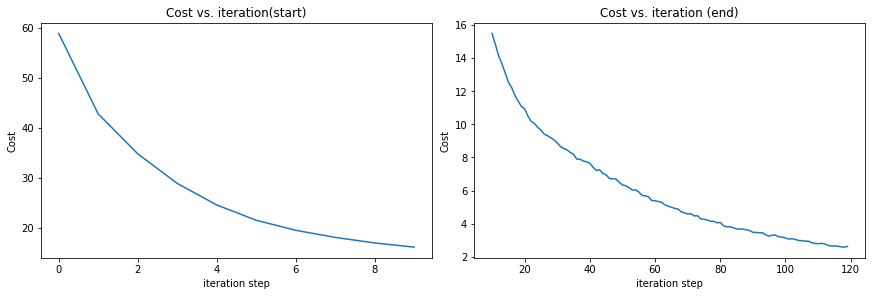

In [44]:
fig, (ax1, ax2) = plt.subplots(1, 2, constrained_layout=True, figsize=(12,4))

ax1.plot(J_hist[:10])
ax2.plot(10 + np.arange(len(J_hist[10:])), J_hist[10:])
ax1.set_title("Cost vs. iteration(start)");  ax2.set_title("Cost vs. iteration (end)")
ax1.set_ylabel('Cost')            ;  ax2.set_ylabel('Cost')
ax1.set_xlabel('iteration step')  ;  ax2.set_xlabel('iteration step')
plt.show()

## 5.5 Inference

#### Infer - beamsearch

In [45]:
from copy import deepcopy


def infer_beam(model, input_sentence,
        X_lexicon,
        Y_lexicon, Y_inverse_lexicon,
        Tx=32, Ty=12, beam_width=5, return_att=False):
    """
    Arguments:
        model (torch model)                 : trained transformer model
        input_sentence (str)                : Input human readable format
        X_lexicon (dict(ch:idx))            : Human dictionary
        Y_lexicon (dict(ch:idx))            : Machine dictionary
        Y_inverse_lexicon (dict(idx:ch))    : Machine inverse dictionary
    Returns:
        output_sentence (str)               : Predicted machine readable format from model
    """
    model.cpu()
    model.eval()
    
    # str -> [37,2,1,56,38] -> tensor(1, Tx)
    X_seq = torch.LongTensor(
        get_feat_tensor([input_sentence], X_lexicon, pad_length=Tx))
    X_mask = create_mask_source(
        X_seq=X_seq,
        pad_token=X_lexicon['<pad>'],
        device='cpu')

    # Init beams: log_prob, Y_seq
    Y_seq = torch.full((1, Ty),
        fill_value=Y_lexicon['<pad>'], dtype=torch.int64)
    Y_seq[:, 0] = Y_lexicon['<start>']
    beams = [(0, Y_seq)]

    # Beam Search
    final_results = []
    for t in range(1, Ty):
        new_beams = []
        for log_prob, Y_seq in beams:
            # Infer
            Y_in = Y_seq[:,:t]
            Y_mask = create_mask_target(
                Y_seq=Y_in,
                pad_token=Y_lexicon['<pad>'],
                device='cpu')
            with torch.no_grad():
                # Y_hat = (1, T, Y_lexicon_size)
                Y_hat, attention = model(
                    X_seq=X_seq, X_mask=X_mask,
                    Y_seq=Y_in, Y_mask=Y_mask)

            # Update beams
            top_log_probs, top_indices = Y_hat[0,t-1,:].topk(beam_width)
            for b in range(beam_width):
                ids = top_indices[b].item()
                log_prob_b = top_log_probs[b].item()
                
                Y_seq_b = deepcopy(Y_seq)
                Y_seq_b[:, t] = ids
                if ids == Y_lexicon['<end>']:
                    final_results.append((
                        log_prob + log_prob_b,
                        Y_seq_b,
                        attention))
                else:
                    new_beams.append((
                        log_prob + log_prob_b,
                        Y_seq_b))
        # Relax beams
        beams = sorted(new_beams, key=lambda x: x[0], reverse=True)[:beam_width]

    # Retrieve best guess Y_seq
    final_results = sorted(final_results, key=lambda x: x[0], reverse=True)
    output_sentence = ''
    # skip <start>
    for ids in final_results[0][1].squeeze(dim=0).tolist()[1:]:
        if Y_inverse_lexicon[ids] == '<end>': break
        output_sentence += Y_inverse_lexicon[ids]

    if return_att == True:
        attention = final_results[0][2]
        return output_sentence, attention
    else:
        
        return output_sentence

In [46]:
print(f'{"[Input]":30} {"[Prediction]":15} {"[Correct Label]":15}')
for i in range(10):
    pred = infer_beam(transformer, X_test[i],
        X_lexicon=X_lexicon,
        Y_lexicon=Y_lexicon, Y_inverse_lexicon=Y_inverse_lexicon,
        Tx=Tx, Ty=Ty-1)
    print(f'{X_test[i]:30} {pred:15} {Y_test[i]:15}')

[Input]                        [Prediction]    [Correct Label]
tuesday november 25 1997       1979-11-25      1997-11-25     
november 22 1981               1981-11-22      1981-11-22     
monday november 18 2002        2020-11-18      2002-11-18     
sunday october 25 1987         1987-10-25      1987-10-25     
28 02 95                       1995-02-28      1995-02-28     
sunday august 15 1971          1971-08-15      1971-08-15     
monday august 2 1993           1993-08-23      1993-08-02     
06 jul 1979                    1979-07-06      1979-07-06     
saturday april 13 1974         1974-04-31      1974-04-13     
sunday april 12 1998           1998-04-12      1998-04-12     


#### Accuracy

In [47]:
# Predict
Y_test_pred = Parallel(n_jobs=8, backend='loky')(delayed(function=infer_beam)(transformer, utt,
    X_lexicon=X_lexicon,
    Y_lexicon=Y_lexicon, Y_inverse_lexicon=Y_inverse_lexicon,
    Tx=Tx, Ty=Ty)
        for utt in tqdm(X_test))

# Acc
scores = [ 1 if Y_test_pred[i] == Y_test[i] else 0 \
    for i in range(len(Y_test)) ]
print(f'Test accuracy = {100.0*sum(scores)/len(Y_test):.3f}%')

100%|██████████| 2000/2000 [01:02<00:00, 31.99it/s]


Test accuracy = 86.050%


## 5.6 Plot Attention

In [48]:
import matplotlib.ticker as ticker


def display_attention(input_sentence, output_sentence, attention):
    """
    Arguments:
        input_sentence (str)                : Input human readable format
        output_sentence (str)               : Predicted machine readable format
        attention (tensor(m, num_heads, T_query, T_key)) : scaled dot product attention
    """
    _, n_heads, _, _ = attention.size()    
    
    in_label = ['<start>']+[c for c in input_sentence]+['<end>']
    out_label = [c for c in output_sentence]+['<end>']
    
    for i in range(n_heads):        
        _attention = attention.squeeze(0)[i,:,:len(in_label)]
        cax = plt.matshow(_attention, cmap='bone')

        plt.tick_params(labelsize=12)
        plt.xticks(np.arange(len(in_label)), in_label, 
            rotation=45)
        plt.yticks(np.arange(len(out_label)), out_label)
        
        if i == 0:
            plt.title(f"{input_sentence} --> {output_sentence}", fontsize=14)
        plt.show()

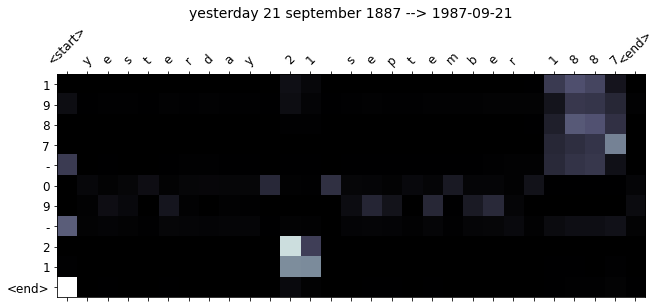

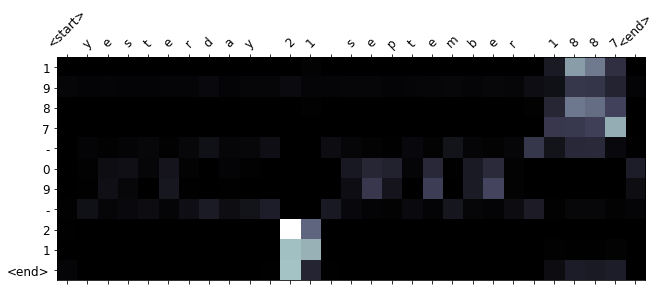

In [49]:
input_sentence = 'yesterday 21 september 1887'
output_sentence, attention = infer_beam(transformer, input_sentence,
    X_lexicon=X_lexicon,
    Y_lexicon=Y_lexicon, Y_inverse_lexicon=Y_inverse_lexicon,
    Tx=Tx, Ty=Ty-1, return_att=True)

display_attention(input_sentence, output_sentence, attention)

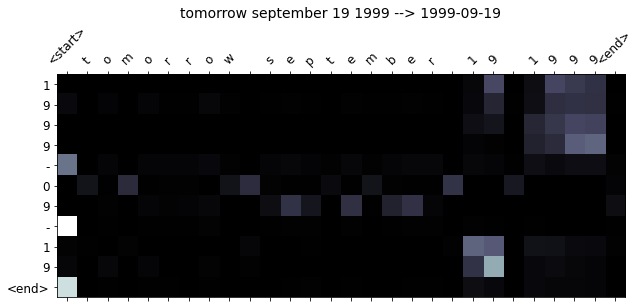

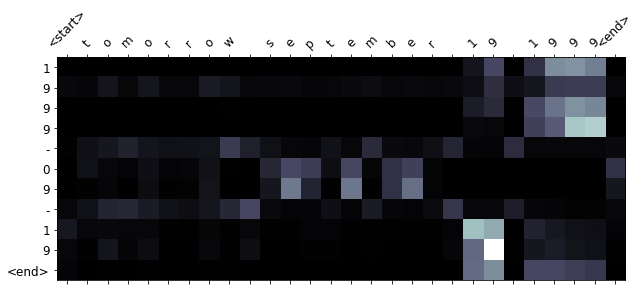

In [50]:
input_sentence = 'tomorrow september 19 1999'
output_sentence, attention = infer_beam(transformer, input_sentence,
    X_lexicon=X_lexicon,
    Y_lexicon=Y_lexicon, Y_inverse_lexicon=Y_inverse_lexicon,
    Tx=Tx, Ty=Ty-1, return_att=True)

display_attention(input_sentence, output_sentence, attention)